<a href="https://colab.research.google.com/github/gautamaman/keyvalue-extraction/blob/main/key_value_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 23.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=b5b3696490a07180b62d796ae8cc26e386f6e36d23a69be73c15d5d6fde5407e
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# install tesseract
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,983 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# if your dataset is in COCO format, register coco format dataset:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("invoices_train", {}, "/content/drive/MyDrive/Invoice_dataset_coco_format/train/dataset.json", "/content/drive/MyDrive/Invoice_dataset_coco_format/train/")
register_coco_instances("invoices_val", {}, "/content/drive/MyDrive/Invoice_dataset_coco_format/val/dataset.json", "/content/drive/MyDrive/Invoice_dataset_coco_format/val/")

[12/21 22:27:26 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Invoice_dataset_coco_format/train/dataset.json takes 2.27 seconds.
[12/21 22:27:26 d2.data.datasets.coco]: Loaded 489 images in COCO format from /content/drive/MyDrive/Invoice_dataset_coco_format/train/dataset.json


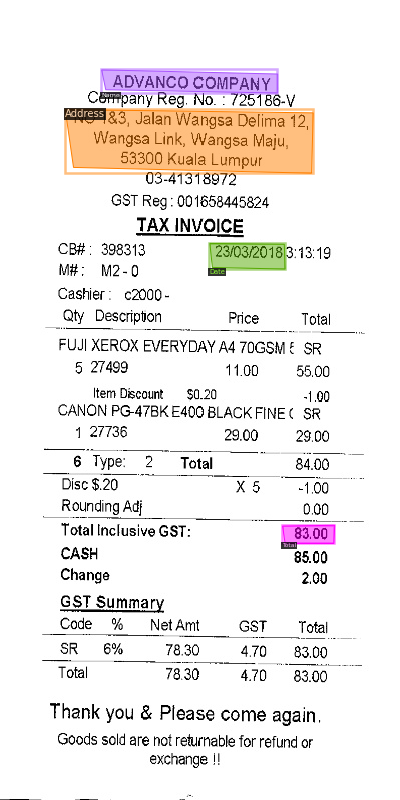

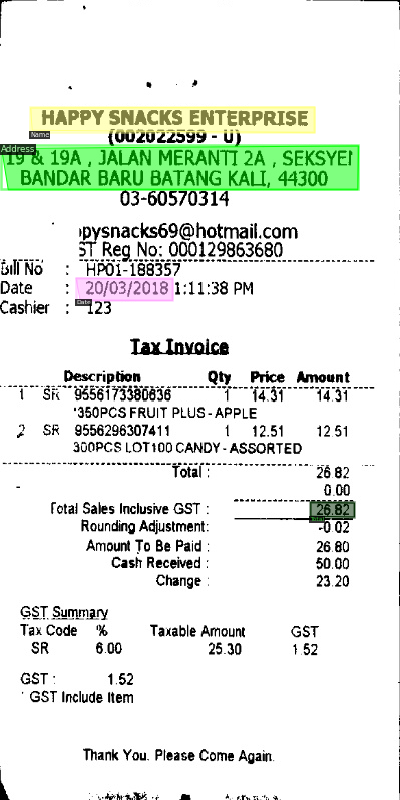

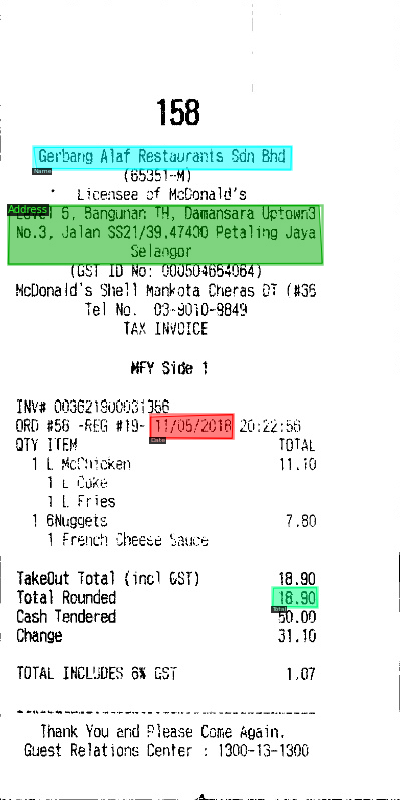

In [ ]:
# Load and visualize training images
train_metadata = MetadataCatalog.get("invoices_train")
dataset_dicts = DatasetCatalog.get("invoices_train")
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1.0)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("invoices_train",)
cfg.DATASETS.TEST = ("invoices_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 # No. of classes = [Name, Address, Date, Total]
cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR = "/content/drive/MyDrive/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/21 22:28:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:06, 24.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[12/21 22:28:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[12/21 22:28:39 d2.utils.events]:  eta: 0:42:58  iter: 19  total_loss: 1.864  loss_cls: 1.123  loss_box_reg: 0.146  loss_rpn_cls: 0.314  loss_rpn_loc: 0.2554  time: 0.8639  data_time: 0.0400  lr: 0.00024976  max_mem: 4254M
[12/21 22:28:57 d2.utils.events]:  eta: 0:43:12  iter: 39  total_loss: 0.9062  loss_cls: 0.3635  loss_box_reg: 0.2304  loss_rpn_cls: 0.1032  loss_rpn_loc: 0.1802  time: 0.8731  data_time: 0.0103  lr: 0.00049951  max_mem: 4254M
[12/21 22:29:14 d2.utils.events]:  eta: 0:43:14  iter: 59  total_loss: 0.809  loss_cls: 0.3593  loss_box_reg: 0.2767  loss_rpn_cls: 0.06198  loss_rpn_loc: 0.1204  time: 0.8780  data_time: 0.0093  lr: 0.00074926  max_mem: 4254M
[12/21 22:29:32 d2.utils.events]:  eta: 0:43:03  iter: 79  total_loss: 0.7855  loss_cls: 0.3243  loss_box_reg: 0.2828  loss_rpn_cls: 0.03907  loss_rpn_loc: 0.1281  time: 0.8825  data_time: 0.0102  lr: 0.00099901  max_mem: 4254M
[12/21 22:29:50 d2.utils.events]:  eta: 0:42:54  iter: 99  total_loss: 0.7523  loss_cls: 0.3044

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/output"

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
cfg.DATASETS.TEST = ("invoices_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_metadata = MetadataCatalog.get("invoices_val")
test_dataset_dicts = DatasetCatalog.get("invoices_val")

from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels
    )
    print(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_boxes)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# crop image and pass it to tesseract using bbox information
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pytesseract
df = pd.DataFrame(columns=['Name', 'Address', 'Total', 'Date'])
for d in random.sample(test_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    pred_classes = outputs["instances"].pred_classes.tolist()
    pred_bboxes = outputs["instances"].pred_boxes.tensor.tolist()
    class_dict = {0: 'Name', 1: 'Address', 2: 'Total', 3: 'Date' }
    name_list = []
    address_list = []
    date_list = []
    total_list = []
    for bbox in range(len(pred_bboxes)):
      tup = (class_dict[pred_classes[bbox]], pred_bboxes[bbox])
      print(tup[0])
      x = int(tup[1][0])
      y = int(tup[1][1])
      w = int(tup[1][2])
      h = int(tup[1][3])
    # x = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][0])
    # y = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][1])
    # w = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][2])
    # h = int(outputs["instances"].pred_boxes[0].tensor.tolist()[0][3])
      crop_img = im[y:h, x:w]
      cv2.imwrite("/content/drive/MyDrive/output/" + "cropped_" + str(bbox) + ".jpg", crop_img)
      print(type(crop_img))
      cv2_imshow(crop_img)
      pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')
      cropped_img = cv2.imread("/content/drive/MyDrive/output/" + "cropped_" + str(bbox) + ".jpg")
      text = pytesseract.image_to_string(cropped_img, lang='eng', config='-psm 1')
      print(text)
      if (tup[0]) == 'Name':
        name_list.append(text)
      elif (tup[0]) == 'Address':
        address_list.append(text)
      elif (tup[0]) == 'Total':
        total_list.append(text)
      elif (tup[0]) == 'Date':
        date_list.append(text)      
    df = df.append({'Name': name_list, 'Address': address_list, 'Total': total_list, 'Date': date_list}, ignore_index=True)
    print(df)
    #df.to_excel("/content/drive/MyDrive/output/sample.xlsx")


In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("invoices_train", cfg, False, output_dir="/content/drive/MyDrive/output/")
val_loader = build_detection_test_loader(cfg, "invoices_train")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)